In [169]:
# preprocess the real data from Elham lab and peprform the archetype analysis
import copy
import importlib
import os
import re
import sys
import os

parent_folder = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_folder)
import anndata
import numpy as np

import pandas as pd
import scanpy as sc

from sklearn.metrics import silhouette_score

import scvi
import seaborn as sns
from anndata import AnnData
from matplotlib import pyplot as plt
from py_pcha import PCHA
from scipy.sparse import issparse
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sympy.physics.units import current
from tqdm import tqdm
from kneed import KneeLocator

import bar_nick_utils
import covet_utils

importlib.reload(bar_nick_utils)
importlib.reload(covet_utils)
from covet_utils import compute_covet

from bar_nick_utils import preprocess_rna, preprocess_protein, plot_archetypes, \
    get_cell_representations_as_archetypes_cvxpy, reorder_rows_to_maximize_diagonal, evaluate_distance_metrics, \
    plot_archetypes_matching, compare_matchings, find_best_pair_by_row_matching, add_spatial_data_to_prot, \
    clean_uns_for_h5ad, get_latest_file

plot_flag = True
# computationally figure out which ones are best
np.random.seed(8)
! which python



/Users/nicholasdjedjos/miniconda3/envs/archetypegen/bin/python


In [170]:
### reading in data (maxfuse adaptation)

In [171]:
# importing data from upenn site
import requests, zipfile, io
r = requests.get("http://stat.wharton.upenn.edu/~zongming/maxfuse/data.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("../")

In [172]:
protein = pd.read_csv("../data/tonsil/tonsil_codex.csv") # ~178,000 codex cells

In [173]:

# input csv contains meta info, take only protein features

protein_features = ['CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8',
       'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'cytokeratin', 'CD2',
       'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IGM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha', 'Ecadherin' ]
# convert to AnnData
protein_locations = ['centroid_x', 'centroid_y']
protein_adata = anndata.AnnData(
    protein[protein_features].to_numpy(), dtype=np.float32
)
# for us, I included spatial data as well (maxfuse doesn't take this into account)
protein_adata.obsm["spatial"] = protein[protein_locations].to_numpy()


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [174]:
# read in RNA data
from scipy.io import mmread

rna = mmread("../data/tonsil/tonsil_rna_counts.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('../data/tonsil/tonsil_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = anndata.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [175]:
# read in celltyle labels (used for evaluation of integration results for maxfuse, but we need them
# for our own analyses)
metadata_rna = pd.read_csv('../data/tonsil/tonsil_rna_meta.csv')
labels_rna = metadata_rna['cluster.info'].to_numpy()
labels_codex = protein['cluster.term'].to_numpy()

protein_adata.obs['cell_types'] = labels_codex
rna_adata.obs['cell_types'] = labels_rna

In [176]:
rna_adata.obs['cell_types'].value_counts()

cell_types
CD4 T          3458
B-CD22-CD40    3454
B-Ki67         2835
Plasma         1665
CD8 T          1420
DC              145
Name: count, dtype: int64

In [177]:
protein_adata.obs['cell_types'].value_counts()

cell_types
B-CD22-CD40    74285
CD4 T          39321
B-Ki67         30985
CD8 T          19827
Plasma         11173
DC              3328
Name: count, dtype: int64

In [178]:
# the next part of maxfuse tutorial 
# does their 1-1 correspondence/fuzzy matching work, but since we don't do this, I don't include it

In [179]:
adata_1 = rna_adata
adata_2 = protein_adata

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


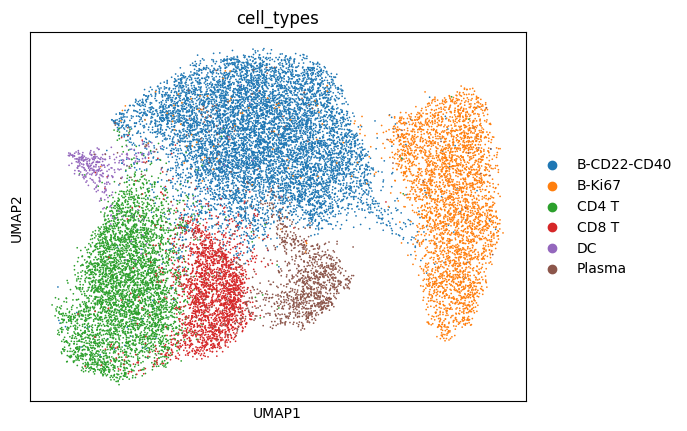

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


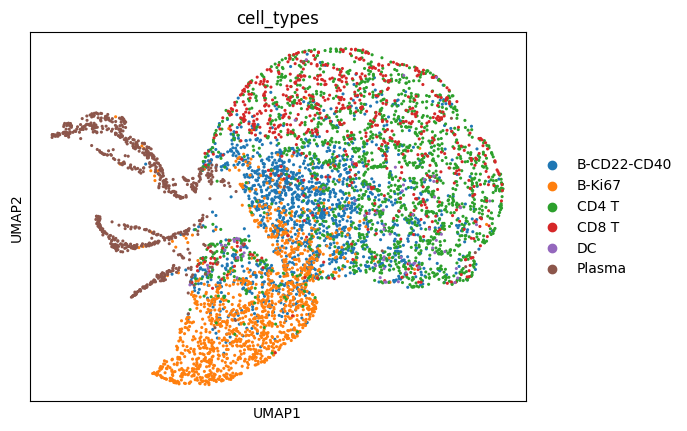

In [180]:
# filter out all tumor type cells
adata_2 = adata_2[adata_2.obs['cell_types'] != 'tumor']
adata_2 = adata_2[adata_2.obs['cell_types'] != 'dead']

num_rna_cells = 6000
num_protein_cells = 20000
# num_rna_cells = num_protein_cells= 1000
subsample_n_obs_rna = min(adata_1.shape[0],num_rna_cells)
subsample_n_obs_protein = min(adata_2.shape[0],num_protein_cells)
sc.pp.subsample(adata_1, n_obs=subsample_n_obs_rna)
sc.pp.subsample(adata_2, n_obs=subsample_n_obs_protein)

# don't have new annotation for maxfuse
# adata_1.obs['cell_types'] = adata_1.obs['new_annotation']
# adata_2.obs['cell_types'] = adata_2.obs['cell_type']

# nk cells seems to mess up the archetype matching, for now remove them
adata_1 = adata_1[adata_1.obs['cell_types'] != 'nk cells'] 
adata_2 = adata_2[adata_2.obs['cell_types'] != 'nk cells']


adata_1 = adata_1[adata_1.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization
# adata_2 = adata_2[adata_2.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization
adata_2 = adata_2[adata_2.obs['cell_types'].argsort(), :]  # sort by cell types for easier visualization

# initial_adata_rna = adata[adata.obs['batch'] == f'SLN111-D1']
# initial_adata_protein = adata[adata.obs['batch'] == f'SLN208-D1'] 
# get rna from one patient, protein from the other then run the whole archetype analysis
# cell type protein, cell type rna, see which one's 
if plot_flag:
    pass  # too long
    sc.pp.pca(adata_2, n_comps=10)
    sc.pp.neighbors(adata_2)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_2)  # Calculate UMAP coordinates
    sc.pl.umap(adata_2, color='cell_types')
    # same for rna
    sc.pp.pca(adata_1, n_comps=10)
    sc.pp.neighbors(adata_1)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_1)  # Calculate UMAP coordinates
    sc.pl.umap(adata_1, color='cell_types')

In [181]:
# make sure we dont have gene column in var if it is equal to the index
if 'gene' in adata_1.var.columns and np.array_equal(adata_1.var['gene'].values, (adata_1.var.index.values)):
    adata_1.var.drop(columns='gene', inplace=True)
if 'gene' in adata_2.var.columns and np.array_equal(adata_2.var['gene'].values, (adata_2.var.index.values)):
    adata_2.var.drop(columns='gene', inplace=True)

In [182]:
# set(adata_1.obs['new_annotation']), set(adata_2.obs['cell_type'])

In [183]:
# filer out the cell types that are not in the other dataset
mutual_cell_types = set(adata_1.obs['cell_types']).intersection(set(adata_2.obs['cell_types']))
adata_1 = adata_1[adata_1.obs['cell_types'].isin(mutual_cell_types)]
adata_2 = adata_2[adata_2.obs['cell_types'].isin(mutual_cell_types)]
adata_1.obs['major_cell_types'] = adata_1.obs['cell_types'].values
adata_2.obs['major_cell_types'] = adata_2.obs['cell_types'].values

/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_83923/736450490.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_1.obs['major_cell_types'] = adata_1.obs['cell_types'].values
/var/folders/gt/1c8d4lks1vgbghz7rr9vnqzm0000gn/T/ipykernel_83923/736450490.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_2.obs['major_cell_types'] = adata_2.obs['cell_types'].values


In [184]:
adata_1.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

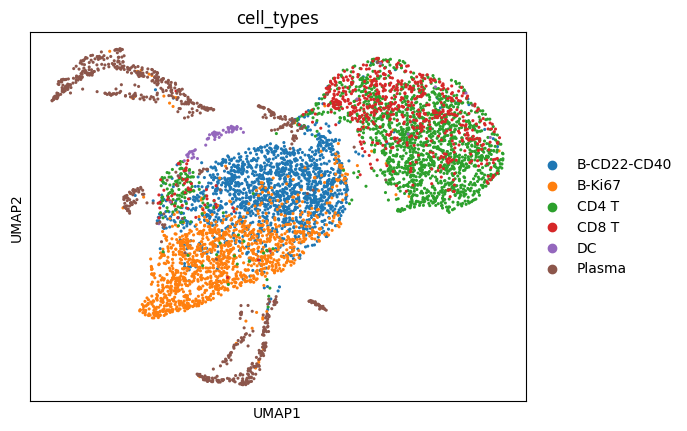

In [185]:

if plot_flag:
    sc.pp.pca(adata_1)
    sc.pp.neighbors(adata_1)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_1)  # Calculate UMAP coordinates
    sc.pl.umap(adata_1, color='cell_types')  

In [186]:
def preprocess_rna_maxfuse(adata_1):
    sc.pp.normalize_total(adata_1)
    sc.pp.log1p(adata_1)
    sc.pp.highly_variable_genes(adata_1, n_top_genes=5000)
    # only retain highly variable genes
    adata_1 = adata_1[:, adata_1.var.highly_variable].copy()
    sc.pp.scale(adata_1)
    return adata_1

In [187]:
preprocess_rna_maxfuse(adata_1)

AnnData object with n_obs × n_vars = 6000 × 5000
    obs: 'cell_types', 'major_cell_types'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'cell_types_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

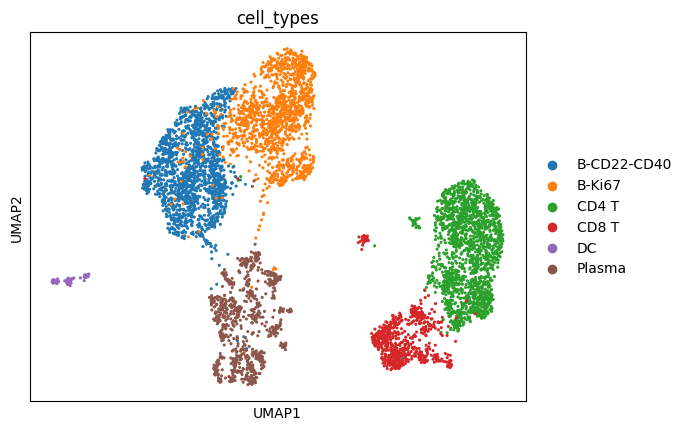

In [188]:
if plot_flag:
    sc.pp.pca(adata_1)
    sc.pp.neighbors(adata_1)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_1)  # Calculate UMAP coordinates
    sc.pl.umap(adata_1, color='cell_types')

In [189]:
adata_1

AnnData object with n_obs × n_vars = 6000 × 33538
    obs: 'cell_types', 'major_cell_types'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'cell_types_colors', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [190]:
# # Filter cells and genes (different sample)
# sc.pp.filter_cells(adata_1, min_genes=100)
# sc.pp.filter_genes(adata_1, min_cells=20)
# # Identify highly variable genes (for further analysis, could narrow down)


# sc.pp.highly_variable_genes(adata_1, n_top_genes=2000, flavor='seurat_v3')

In [191]:

# Scatter plot of variance vs. mean expression
# common approach to inspect the variance of genes. It shows the relationship between mean expression and variance (or dispersion) and highlights the selected highly variable genes.

# if plot_flag:
#     plt.figure(figsize=(8, 6))
#     plt.scatter(adata_1.var['means'], adata_1.var['variances'], alpha=0.3, label='All genes')
#     plt.scatter(adata_1.var['means'][adata_1.var['highly_variable']],
#                 adata_1.var['variances'][adata_1.var['highly_variable']],
#                 color='red', label='Highly variable genes')
#     plt.xlabel('Mean expression')
#     plt.ylabel('Variance')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.legend()
#     plt.title('Variance vs. Mean Expression of Genes')
#     plt.show()

In [192]:
# plt.figure(figsize=(8, 6))
# plt.hist(adata_1.var['variances'], bins=75, alpha=0.7)
# plt.axvline(x=adata_1.var['variances'][adata_1.var['highly_variable']].min(), color='red', linestyle='dashed', label='Cutoff')
# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.yscale('log')
# plt.title('Distribution of Gene Variances')
# plt.legend()
# plt.show()

In [193]:
# variances_sorted = np.sort(adata_1.var['variances'])[::-1]

# if plot_flag:
#     plt.figure(figsize=(8, 6))
#     plt.plot(range(1, len(variances_sorted) + 1), variances_sorted)
#     plt.xlabel('Gene rank')
#     plt.ylabel('Variance')
#     # plt.xscale('log')

#     plt.yscale('log')
#     plt.title('Elbow plot of Gene Variances')
#     plt.axvline(x=1000, color='red', linestyle='dashed', label='n_top_genes=1000')
#     plt.legend()
#     plt.show()
#     plt.figure()
# kneedle = KneeLocator(range(1, len(variances_sorted) + 1), np.log(variances_sorted), S=2.0, curve="convex",
#                       direction="decreasing")
# if plot_flag:
#     kneedle.plot_knee()


In [194]:
# print(kneedle.knee)

In [195]:
# sc.pp.highly_variable_genes(adata_1, n_top_genes=kneedle.knee, flavor='seurat_v3')

In [196]:
adata_1 = adata_1[:, adata_1.var['highly_variable']]


print(f"Selected {adata_1.shape[1]} highly variable genes.")
# PCA after selecting highly variable genes
sc.pp.pca(adata_1)
print(
    f"Variance ratio after highly variable gene selection PCA (10 PCs): {adata_1.uns['pca']['variance_ratio'][:10].sum():.4f}")



Selected 5000 highly variable genes.
Variance ratio after highly variable gene selection PCA (10 PCs): 0.3424


/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [197]:
adata_1 = adata_1[
    adata_1.obs.sort_values(by=['cell_types']).index
]

adata_2 = adata_2[
    adata_2.obs.sort_values(by=['cell_types']).index
]


In [198]:
# initial adata code (different samples) (takes a little while longer for some reason)
# make sure I do this to adata_2 as well

adata_1_rna = adata_1.copy()
sc.pp.pca(adata_1_rna)
print(f'variance explained by first 10 PCs {adata_1_rna.uns["pca"]["variance_ratio"][:10].sum()}')
# adata_1_rna = preprocess_rna(adata_1_rna)
sc.pp.pca(adata_1_rna)

variance explained by first 10 PCs 0.34237945079803467


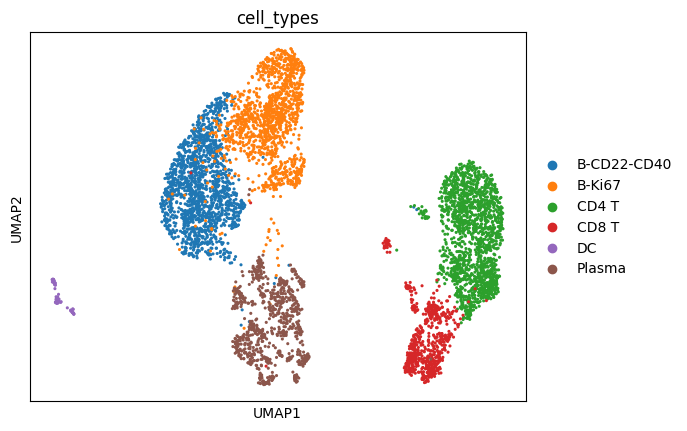

In [199]:
if plot_flag:
    sc.pp.neighbors(adata_1_rna)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_1_rna)  # Calculate UMAP coordinates
    sc.pl.umap(adata_1_rna, color='cell_types')

In [200]:
# adata_1_rna.obsm.pop('protein_expression')
# assert len(set(adata.obs['batch']))!=1
adata_2_prot = adata_2
# # add all obs and var to adata_prot
# adata_prot.obs = adata_rna.obs (this is a potential problem as rna and protein obs don't match currently)


In [201]:
sc.pp.filter_cells(adata_2_prot, min_genes=30)
sc.pp.filter_genes(adata_2_prot, min_cells=50)

/Users/nicholasdjedjos/miniconda3/envs/archetypegen/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:168: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


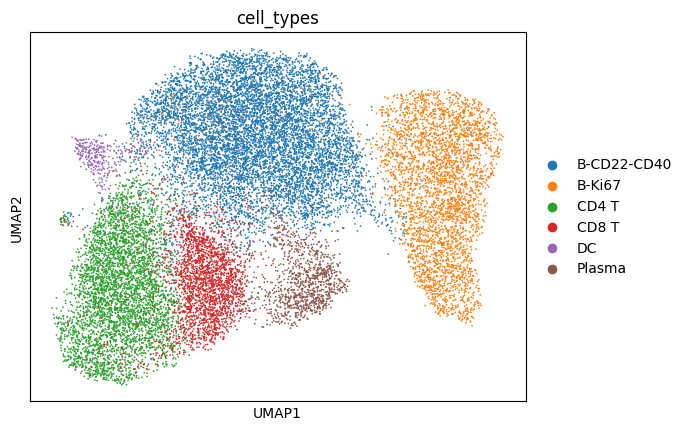

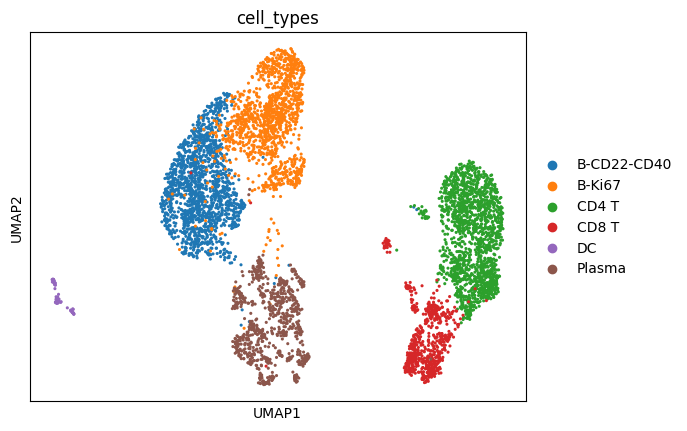

In [202]:
if plot_flag:
    sc.pp.pca(adata_2_prot)
    sc.pp.neighbors(adata_2_prot)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_2_prot)  # Calculate UMAP coordinates
    sc.pl.umap(adata_2_prot, color='cell_types')
    # same for rna
    sc.pp.pca(adata_1_rna)
    sc.pp.neighbors(adata_1_rna)  # Compute the neighbors needed for UMAP
    sc.tl.umap(adata_1_rna)  # Calculate UMAP coordinates
    sc.pl.umap(adata_1_rna, color='cell_types')

In [203]:
# adata_2_prot.obs = adata_2_prot.obs.drop(columns=['n_genes'])
# adata_2_prot = preprocess_protein(adata_2_prot)
# adata_2_prot.obsm.pop('X_pca')
# adata_2_prot.varm.pop('PCs')
# original_protein_num = adata_2_prot.X.shape[1]

In [204]:
adata_2_prot.obs['major_cell_types'].unique()
adata_2_prot.obs['cell_types'].unique()

['B-CD22-CD40', 'B-Ki67', 'CD4 T', 'CD8 T', 'DC', 'Plasma']
Categories (6, object): ['B-CD22-CD40', 'B-Ki67', 'CD4 T', 'CD8 T', 'DC', 'Plasma']

In [205]:
adata_2_prot

AnnData object with n_obs × n_vars = 19747 × 46
    obs: 'cell_types', 'major_cell_types', 'n_genes'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'umap', 'cell_types_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [206]:

assert adata_2_prot.obs.index.is_unique

# this is commented out because we will use the actual spatial data
# adata_2_prot,horizontal_splits,vertical_splits = add_spatial_data_to_prot(adata_2_prot, major_to_minor_dict) 
# adata_2_prot.obsm['spatial_location'] = pd.DataFrame([adata_2_prot.obs['X'],adata_2_prot.obs['Y']]).T
x_coor = adata_2_prot.obsm['spatial'][:, 0]
y_coor = adata_2_prot.obsm['spatial'][:, 1]
temp = pd.DataFrame([x_coor, y_coor], index=['x', 'y']).T
temp.index = adata_2_prot.obs.index
adata_2_prot.obsm['spatial_location'] = temp
adata_2_prot.obs['X'] = x_coor
adata_2_prot.obs['Y'] = y_coor
plot_flag = False
if plot_flag:
    sc.pl.scatter(adata_2_prot[adata_2_prot.obs['major_cell_types'] == 'T-reg'], x='X', y='Y', color='cell_types',
                  title='B Cell subtypes locations')
    # sc.pl.scatter(adata_2_prot[adata_2_prot.obs['major_cell_types']=='CD4 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')
    # sc.pl.scatter(adata_2_prot[adata_2_prot.obs['major_cell_types']=='CD8 T'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')

In [207]:
clean_uns_for_h5ad(adata_2_prot)
clean_uns_for_h5ad(adata_1_rna)
time_stamp = pd.Timestamp.now().strftime("%Y-%m-%d-%H-%M-%S")
adata_1_rna.write(f'data/preprocessed_adata_rna_maxfuse_{time_stamp}.h5ad')
adata_2_prot.write(f'data/preprocessed_adata_prot_maxfuse_{time_stamp}.h5ad')
